In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10') #'science')
plt.rcParams['font.family'] = 'serif'

In [2]:
def compute_confidence_levels(truths, posterior_samples, refs='truths'):
    truths = truths[np.newaxis, :, :]
    low = np.min(truths, axis=1, keepdims=True)
    high = np.max(truths, axis=1, keepdims=True)
    samples = (posterior_samples - low) / (high - low + 1e-10)
    theta = (truths - low) / (high - low + 1e-10)
    
    # Generate reference points
    if refs == 'truths':
        references = np.random.uniform(low=0, high=1, size=(n_sims, 1))
    elif refs == 'samples':
        references = np.random.uniform(samples.min(), samples.max(), size=(n_sims, 1)) 
        
    # Compute distances
    samples_distances = np.sqrt(
        np.sum((references[np.newaxis] - samples) ** 2, axis=-1)
    )
    theta_distances = np.sqrt(np.sum((references - theta) ** 2, axis=-1))
    f = np.sum((samples_distances < theta_distances), axis=0) /n_samples 

    # Compute confidence levels
    num_alpha_bins = 30 
    h, alpha = np.histogram(f, density=True, bins=num_alpha_bins, range=(0,1))

    dx = alpha[1] - alpha[0]
    ecp = np.cumsum(h) * dx
    x,y = np.concatenate([[0], ecp]), alpha
    return x, y, f



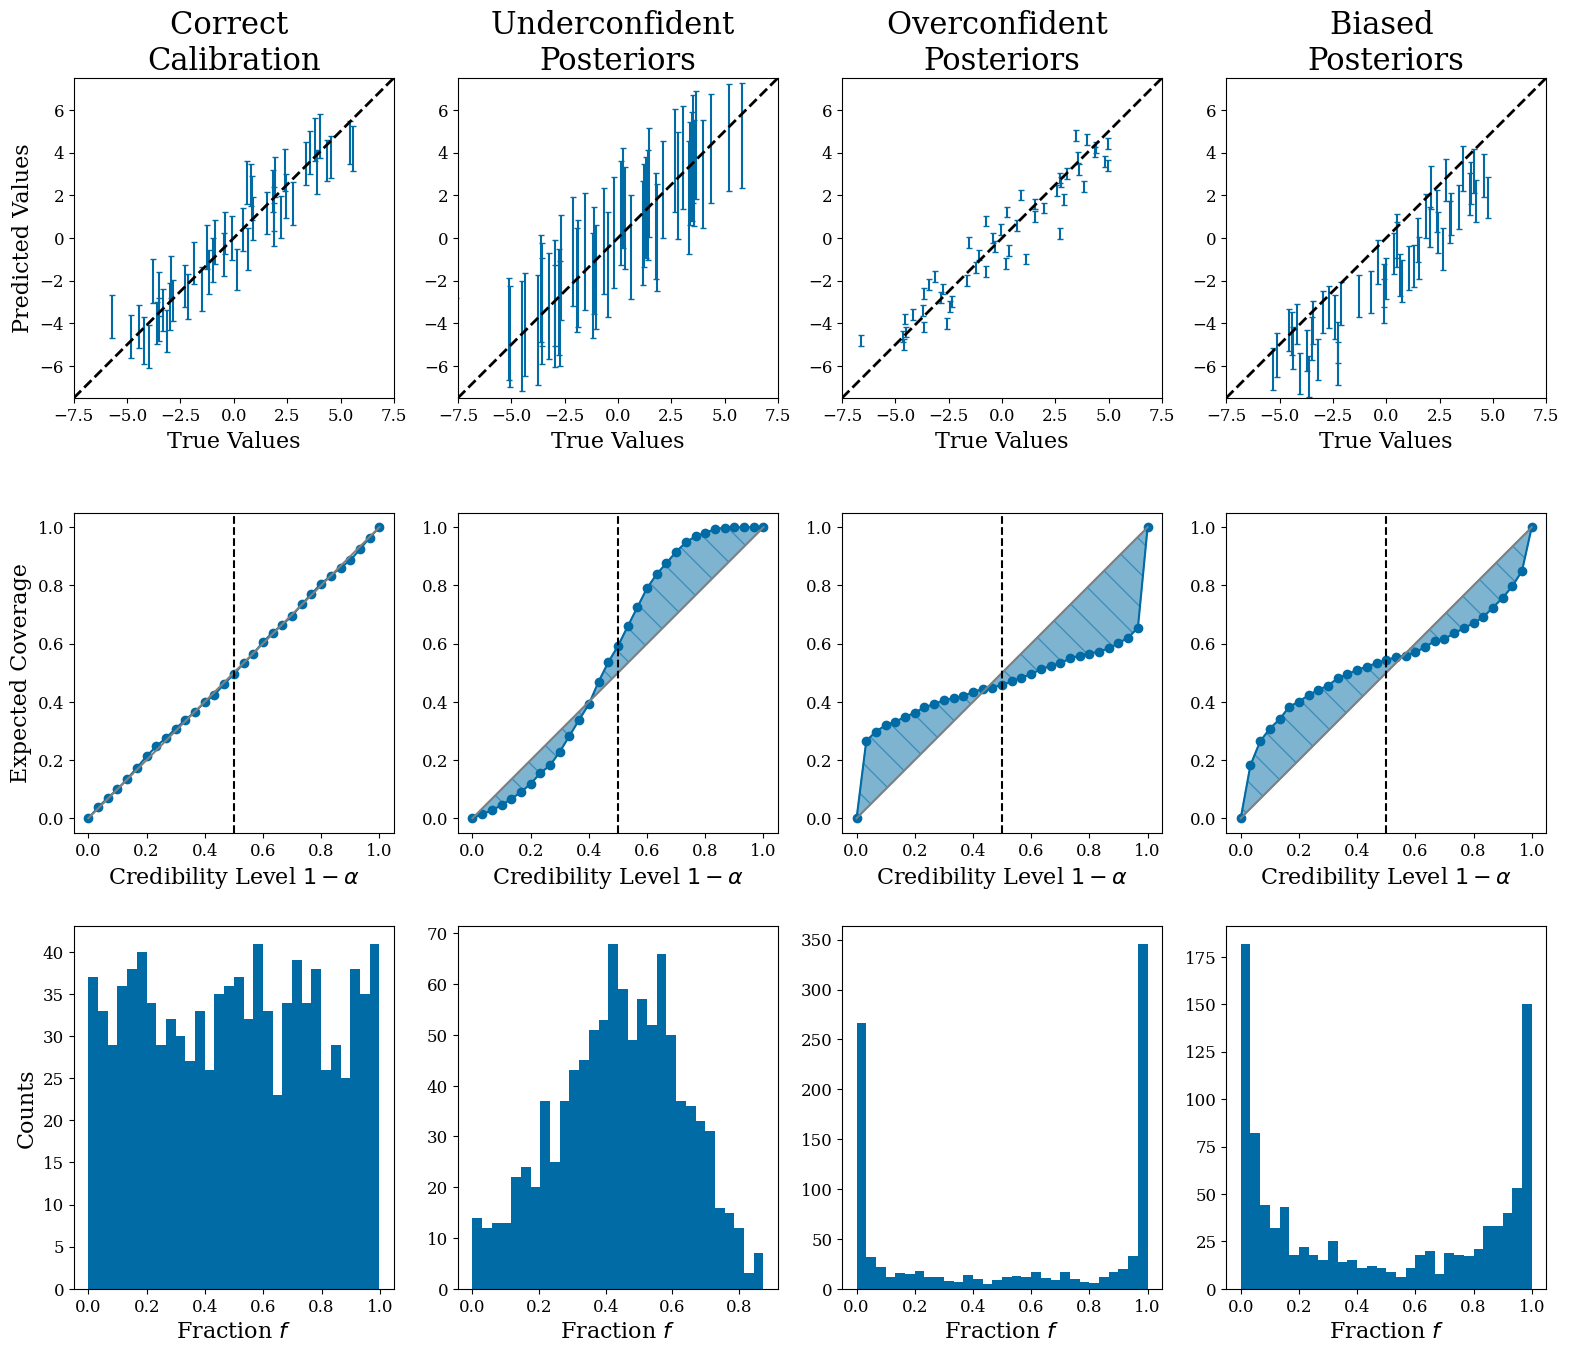

In [3]:
# generate points from gaussian distribution
n_samples = 500
n_sims = 1000

mean_vals = np.linspace(-5, 5, num=n_sims)

# Perfect calibration
truths_p = np.random.normal(loc=mean_vals, scale=1.,)[:,None] 
samples_p = np.random.normal(loc=mean_vals, scale=1., size=(n_samples, n_sims))[:,:, None] 

truths_uc = np.random.normal(loc=mean_vals, scale=1.,)[:,None] 
samples_uc = np.random.normal(loc=mean_vals, scale=2.5, size=(n_samples, n_sims))[:,:, None] 

truths_oc = np.random.normal(loc=mean_vals, scale=1.,)[:,None] 
samples_oc = np.random.normal(loc=mean_vals, scale=0.25, size=(n_samples, n_sims))[:,:, None] 

truths_b = np.random.normal(loc=mean_vals, scale=1.,)[:,None] 
samples_b = np.random.normal(loc=mean_vals-1.5, scale=1., size=(n_samples, n_sims))[:,:, None] 

truths_all = [truths_p, truths_uc, truths_oc, truths_b]
samples_all = [samples_p, samples_uc, samples_oc, samples_b]
titles_all = ['Correct \nCalibration', 'Underconfident \nPosteriors', 
             'Overconfident \nPosteriors', 'Biased \nPosteriors']
# Plot the results
labelsize=16
titlesize=22
ticksize=12

fig, axs = plt.subplots(3, 4, figsize=(19, 16), #constrained_layout=True, 
                        gridspec_kw={'height_ratios': [1, 1, 1], 'width_ratios': [1, 1, 1, 1]})
plt.subplots_adjust(wspace=0.2, hspace=0.2)
# Plot true vs predicted values
for col, (truths, samples, title) in enumerate(zip(truths_all, samples_all, titles_all)):
    x, y, f = compute_confidence_levels(truths, samples)
    
    # Plot truths vs predictions
    axs[0, col].set_title(title, fontsize=titlesize)
    axs[0, col].errorbar(truths[::20].squeeze(-1),
                         samples.mean(axis=0).squeeze(-1)[::20], 
                         yerr=samples.std(axis=0).squeeze(-1)[::20],
                         capsize=2, ls=' ')
    axs[0, col].axline((0, 0), slope=1, c='k', ls='--', lw=2) #plot([-5, 5], [-5, 5], c='k', ls='--', lw=2)
    axs[0, col].set_aspect('equal')
    axs[0, col].set_xlabel('True Values', fontsize=labelsize)
    if col == 0:
        axs[0, col].set_ylabel('Predicted Values', fontsize=labelsize)
    axs[0, col].set_ylim(-7.5, 7.5)
    axs[0, col].set_xlim(-7.5, 7.5)
    axs[0, col].tick_params(axis='both', which='major', labelsize=ticksize)

    # Plot confidence levels
    if col == 0:
        axs[1, col].set_ylabel('Expected Coverage', fontsize=labelsize)
    axs[1, col].set_xlabel(fr'Credibility Level $1 - \alpha$', fontsize=labelsize)
    axs[1, col].plot(y, x, label='ECP', marker='o')
    axs[1, col].plot(x, x, color='gray')
    if col != 0:
        axs[1, col].fill_between(y, x, y2=y, alpha=0.5, hatch='\\', edgecolor='C0', )
    axs[1, col].axvline(0.5, c='k', ls='--')
    axs[1, col].set_aspect('equal')
    axs[1, col].tick_params(axis='both', which='major', labelsize=ticksize)

    # Plot histogram of fractions
    if col == 0:
        axs[2, col].set_ylabel('Counts', fontsize=labelsize)
    axs[2, col].set_xlabel(fr'Fraction $f$', fontsize=labelsize)
    axs[2, col].hist(f, x.shape[0] - 1)
    axs[2, col].tick_params(axis='both', which='major', labelsize=ticksize)

plt.savefig(f'plots/appendix_toy_example_TARP.pdf', bbox_inches='tight')    